In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
#from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [ ]:
normal_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/normal',224))
osteoarthritis_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/osteoarthritis',224))
normal_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/normal',224))
osteoarthritis_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/osteoarthritis',224))

100%|██████████| 276/276 [00:01<00:00, 250.08it/s]


In [ ]:
print(len(osteoarthritis_train))

1971


In [ ]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
osteoarthritis_train_label = np.ones(len(osteoarthritis_train))
normal_test_label = np.zeros(len(normal_test))
osteoarthritis_test_label = np.ones(len(osteoarthritis_test))

In [ ]:
# Merge data
X_train = np.concatenate((normal_train, osteoarthritis_train), axis = 0)
Y_train = np.concatenate((normal_train_label, osteoarthritis_train_label), axis = 0)
X_test = np.concatenate((normal_test, osteoarthritis_test), axis = 0)
Y_test = np.concatenate((normal_test_label, osteoarthritis_test_label), axis = 0)


In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=20
)

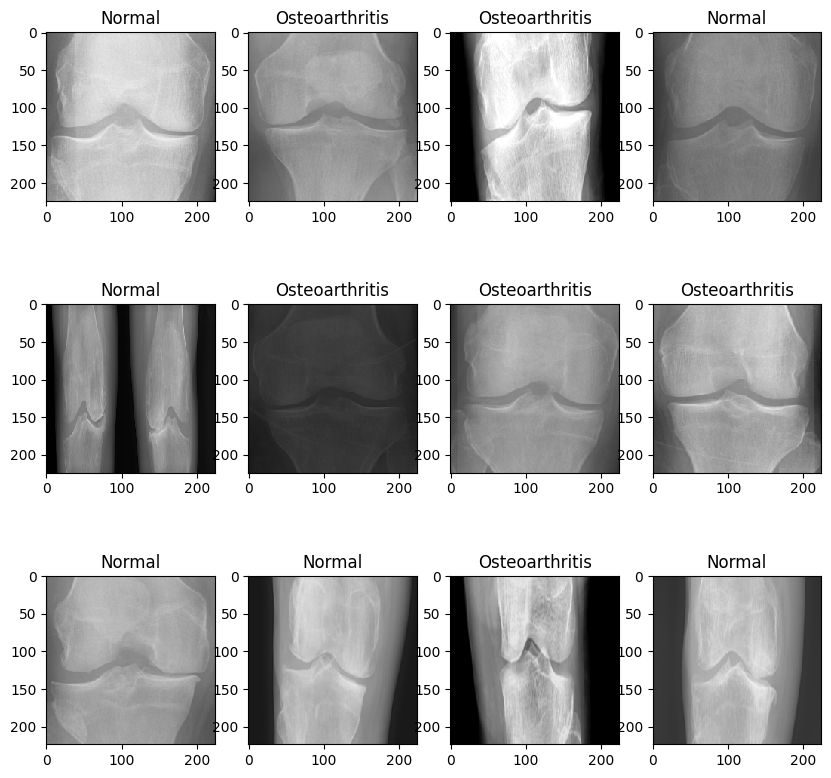

In [ ]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(10,10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Osteoarthritis')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 64

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=6,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

vgg = ResNet50(include_top=False, input_shape=input_shape)(inputs)

In [ ]:
outputs = GlobalAveragePooling2D()(vgg)
# outputs = Dropout(0.4)(outputs)
# outputs = BatchNormalization()(outputs)
# outputs = Dense(32,activation='relu')(outputs)
# outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23600002 (90.03 MB)
Trainable params: 2354278

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.1, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/resnet1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=2,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-24-ed889d48d8e2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
38/37 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.6819

37/37 [==============================] - 58s 1s/step - loss: 0.6634 - accuracy: 0.6819 - val_loss: 2.1818 - val_accuracy: 0.4457 - lr: 1.0000e-04
Epoch 2/2
38/37 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.7563

37/37 [==============================] - 51s 1s/step - loss: 0.5551 - accuracy: 0.7563 - val_loss: 1.5970 - val_accuracy: 0.5326 - lr: 1.0000e-04


27/27 [==============================] - 4s 90ms/step
Confusion matrix, without normalization
[[476  93]
 [ 77 199]]


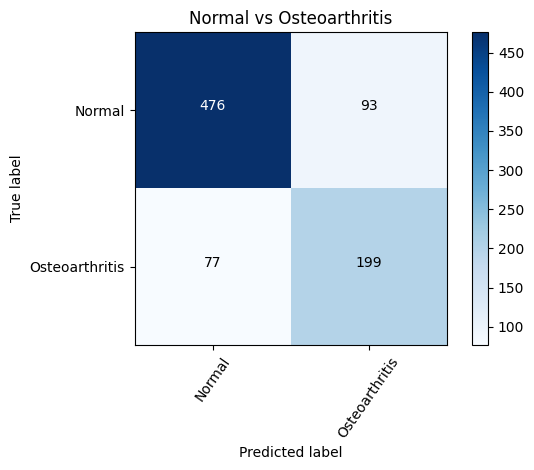

In [ ]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Osteoarthritis']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Osteoarthritis')

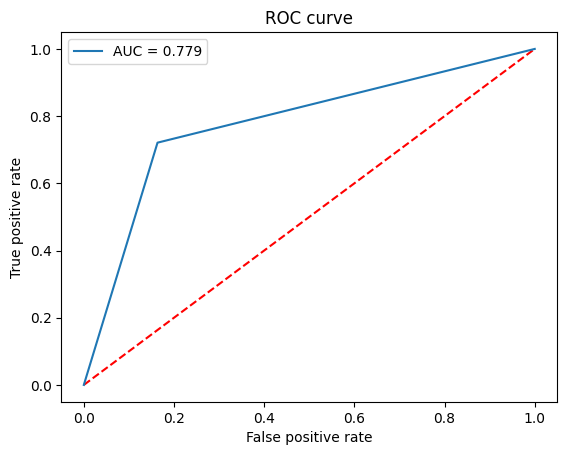

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

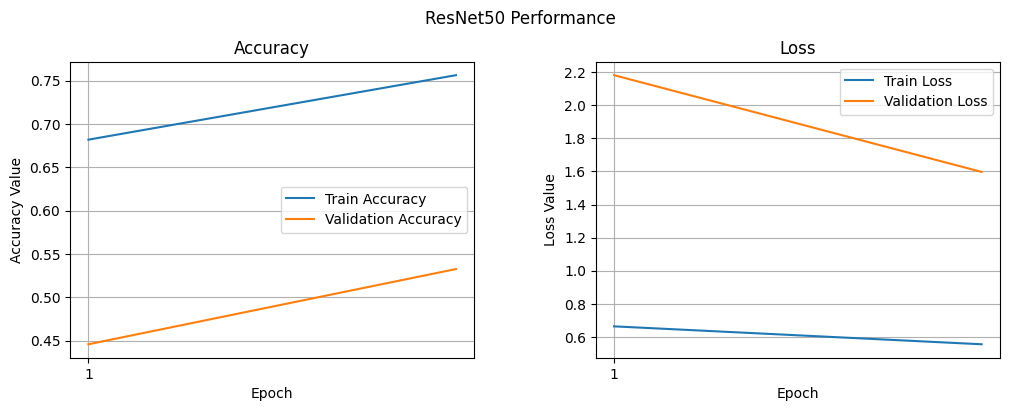

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ResNet50 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,3))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 3, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 3, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

27/27 [==============================] - 2s 87ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Normal', 'Osteoarthritis']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
                precision    recall  f1-score   support

        Normal       0.86      0.84      0.85       569
Osteoarthritis       0.68      0.72      0.70       276

      accuracy                           0.80       845
     macro avg       0.77      0.78      0.77       845
  weighted avg       0.80      0.80      0.80       845

